In [1]:
# Copyright © 2020, Johan Vonk
# SPDX-License-Identifier: MIT

In [2]:
!pip install -U tensorflow-addons # install the latest version to fix bug with AdamW optimizer

     |████████████████████████████████| 1.1MB 2.8MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import json

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
seed = 7 # seed the random function to a result that avoids most local minima
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
@tf.function
@tf.custom_gradient
def scaled_swish(features):
    scale=tf.constant(1.78718727865)
    diff=tf.constant(0.20662096414)
    sigmoid_features = tf.math.sigmoid(features)
    @tf.function
    def grad(dy):
        return dy * (sigmoid_features * (1 + features * (1 - sigmoid_features))) * scale
    return (features * tf.math.sigmoid(features)-diff) * scale, grad

In [6]:
sample_rate = 0.15
samples = 50
batch_size = 48
epochs_base = 52
epochs = 10
steps_per_epoch = 10000
group_size = 10000 # must be multiple of 100 so probabilities divide evenly
initial_lr=0.0001
epochs_per_restart=4
wd_coefficient=0.2
quantiles=[0.50,0.1,0.9,0.02,0.98,0.005,0.995]
alpha=0.0
grid_sizes=[3,5,10,20]
activation=scaled_swish
initializer=tf.keras.initializers.TruncatedNormal(mean=0.0,stddev=samples/3.0)
step = tf.Variable(0, trainable=False)
schedule=tf.keras.experimental.CosineDecayRestarts(initial_lr,steps_per_epoch*epochs_per_restart,alpha=alpha,t_mul=1.5)
lr = schedule(step)
wd = wd_coefficient * schedule(step) * (schedule(step)/initial_lr-alpha)**2

In [7]:
modes=[tfp.distributions.Deterministic(0.0),    # not moving
       tfp.distributions.LogNormal(1.482,0.405), # bike
       tfp.distributions.Normal(1.35,0.5),  # walk
       tfp.distributions.LogNormal(0.993,0.0488)] # run
p=tf.constant([[48,3, 9, 2],
               [1, 4, 2, 1],
               [2, 2, 14,4],
               [1, 1, 4, 2]])
RSSI_to_distance=tf.function(lambda x:tf.math.pow(10.0,(-62.235-x)/30.9))
distance_to_RSSI=tf.function(lambda x,N:-62.235-tf.math.log(x)/tf.math.log(10.0)*N*10)
closest_road=tfp.distributions.Normal(3.5,1.0)
closest_nonroad=tfp.distributions.LogNormal(0.486,2.0)
closest_possible=0.05
same_direction=tfp.distributions.Bernoulli(probs=0.6)
first_sample=tfp.distributions.Normal(-95.0,5.0)
rssi_var_normal=tfp.distributions.Normal(-2.308,4.904)
rssi_var_exponential=tfp.distributions.Exponential(0.4348)
N_var=tfp.distributions.LogNormal(0.0861776962,0.115)
wall_chance=tfp.distributions.Bernoulli(probs=0.1)
wall_distribution=tfp.distributions.LogNormal(2.2,0.4)
obstruction_chance=tfp.distributions.Bernoulli(probs=0.3)
obstruction_distribution=tfp.distributions.LogNormal(0.8,0.4)

def distance_var(x,obstructions):
    N_variations=tf.transpose(tf.repeat(N_var.sample(x.shape[0])[None]+2.0,samples,0))
    variated_distances=distance_to_RSSI(x,N_variations)+rssi_var_normal.sample(x.shape)+rssi_var_exponential.sample(x.shape)
    if obstructions:
        variated_distances+=tf.transpose(tf.repeat((tf.cast(wall_chance.sample(x.shape[0]),tf.float32)*wall_distribution.sample(x.shape[0]))[None],samples,0))
        variated_distances+=tf.transpose(tf.repeat((tf.cast(obstruction_chance.sample(x.shape[0]),tf.float32)*obstruction_distribution.sample(x.shape[0]))[None],samples,0))
    return variated_distances

def distance(n):
    deltas=tf.random.shuffle(tf.math.abs(tf.concat([
                        tf.concat([mode1.sample(x)+mode2.sample(x)*tf.cast(same_direction.sample(x)*2-1,tf.float32)
                        for x, mode2 in zip(row,modes)],axis=-1)
                    for row, mode1 in zip(p*n//100,modes)],axis=-1)))*sample_rate
    shifts=tf.random.uniform([n],-deltas/2,deltas/2)
    starts=RSSI_to_distance(first_sample.sample(n))-shifts
    ends=-RSSI_to_distance(first_sample.sample(n))+shifts
    centers=tf.where(deltas==0,ends,tf.random.uniform(ends.shape,minval=starts,maxval=ends))
    sampled_distances=tf.transpose(tf.math.abs(tf.convert_to_tensor(np.linspace(centers-deltas*samples/2,centers+deltas*samples/2,samples, axis=0), tf.float32)))
    closest_points=tf.transpose(tf.repeat(tf.random.shuffle(tf.concat([tf.math.abs(closest_road.sample(n//2)),closest_nonroad.sample(n//2)],axis=-1)+closest_possible)[None],samples,0))
    return tf.math.sqrt(tf.math.square(sampled_distances)+tf.math.square(closest_points))

def generate_data(batch_size, obstructions):
    while True:
        y=distance(batch_size*group_size)
        x=distance_var(y, obstructions)
        for i in range(0, batch_size*group_size, batch_size):
            yield tf.convert_to_tensor(x[i:i+batch_size],dtype=tf.float32), tf.convert_to_tensor(y[i:i+batch_size],dtype=tf.float32)

In [8]:
y_test=distance(steps_per_epoch*batch_size)
x_test=distance_var(y_test, True) # include obstructions including walls only in the validation set to show model generalizes well 

In [9]:
class LearningRateTracker(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        logs['lr']=K.eval(schedule(steps_per_epoch*(epoch+1)-1)) # print learning rate for cosine annealing at the end of every epoch

In [10]:
def train(quantile,epochs,loss,obstructions):
    model = Sequential(name=str(quantile))
    model.add(Lambda(RSSI_to_distance, input_shape=(samples,)))
    model.add(Dense(samples*4, kernel_initializer=initializer, activation=activation))
    model.add(Dense(samples*3, kernel_initializer=initializer, activation=activation))
    model.add(Dense(samples*2, kernel_initializer=initializer, activation=activation))
    model.add(Dense(samples, kernel_initializer=initializer, activation=activation))
    model.compile(loss=loss,
                  metrics=['mae','mse','logcosh','mape'],
                  optimizer=tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd, amsgrad=True))
    if quantile != 'base':
        model.load_weights(f'model-rssi-line{samples}-base.hdf5')
    history = model.fit(generate_data(batch_size, obstructions), validation_data=(x_test,y_test), epochs=epochs, batch_size=batch_size, steps_per_epoch=steps_per_epoch, callbacks=[LearningRateTracker()])
    model.save(f'model-rssi-line{samples}-{quantile}.hdf5')
    json.dump(str(history.history),open(f'model-rssi-line{samples}-{quantile}.json', "w+"))
    np.save(f'model-rssi-line{samples}-{quantile}.npy',model.predict(x_test))

In [ ]:
train('base',epochs_base,'msle',False) # MSLE since we really want something that scales inversely with distance and MAPE would lead to problems near zero (model fit to 0 for some values)

Epoch 1/52
10000/10000 [==============================] - 51s 5ms/step - loss: 1.5925 - mae: 5.5538 - mse: 1042.5970 - logcosh: 5.0187 - mape: 36.7772 - val_loss: 1.5277 - val_mae: 5.9725 - val_mse: 1157.8668 - val_logcosh: 5.4169 - val_mape: 37.4669 - lr: 8.5358e-05
Epoch 2/52
10000/10000 [==============================] - 49s 5ms/step - loss: 1.0518 - mae: 4.2649 - mse: 623.0919 - logcosh: 3.7611 - mape: 26.5743 - val_loss: 0.6111 - val_mae: 4.0214 - val_mse: 689.1968 - val_logcosh: 3.4959 - val_mape: 24.1368 - lr: 5.0004e-05
Epoch 3/52
10000/10000 [==============================] - 51s 5ms/step - loss: 0.5606 - mae: 3.1633 - mse: 460.6713 - logcosh: 2.6803 - mape: 18.8978 - val_loss: 0.6114 - val_mae: 4.0223 - val_mse: 687.7065 - val_logcosh: 3.4985 - val_mape: 23.9584 - lr: 1.4647e-05
Epoch 4/52
10000/10000 [==============================] - 51s 5ms/step - loss: 0.5601 - mae: 3.1880 - mse: 546.3215 - logcosh: 2.7064 - mape: 18.7596 - val_loss: 0.6103 - val_mae: 3.9979 - val_mse: 68

In [11]:
for quantile in quantiles:
    train(quantile,epochs,tfa.losses.PinballLoss(tau=quantile),True) # train to predict median and other quantiles with pinball loss, this gives a good measure of uncertainty

Epoch 1/10
10000/10000 [==============================] - 38s 4ms/step - loss: 1.3801 - mae: 2.7602 - mse: 357.3303 - logcosh: 2.2372 - mape: 16.9654 - val_loss: 1.4023 - val_mae: 2.8045 - val_mse: 433.3242 - val_logcosh: 2.2741 - val_mape: 17.4216 - lr: 8.5358e-05
Epoch 2/10
10000/10000 [==============================] - 37s 4ms/step - loss: 1.3880 - mae: 2.7759 - mse: 300.4054 - logcosh: 2.2536 - mape: 16.9839 - val_loss: 1.3819 - val_mae: 2.7637 - val_mse: 418.7020 - val_logcosh: 2.2478 - val_mape: 16.4040 - lr: 5.0004e-05
Epoch 3/10
10000/10000 [==============================] - 37s 4ms/step - loss: 1.4201 - mae: 2.8402 - mse: 827.2748 - logcosh: 2.3165 - mape: 17.2119 - val_loss: 1.3880 - val_mae: 2.7761 - val_mse: 423.1784 - val_logcosh: 2.2521 - val_mape: 17.1481 - lr: 1.4647e-05
Epoch 4/10
10000/10000 [==============================] - 37s 4ms/step - loss: 1.4080 - mae: 2.8160 - mse: 444.6760 - logcosh: 2.2938 - mape: 17.0783 - val_loss: 1.3874 - val_mae: 2.7749 - val_mse: 418.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning

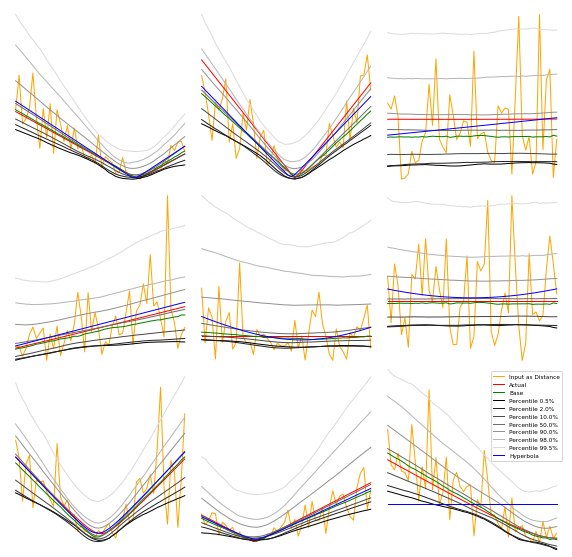

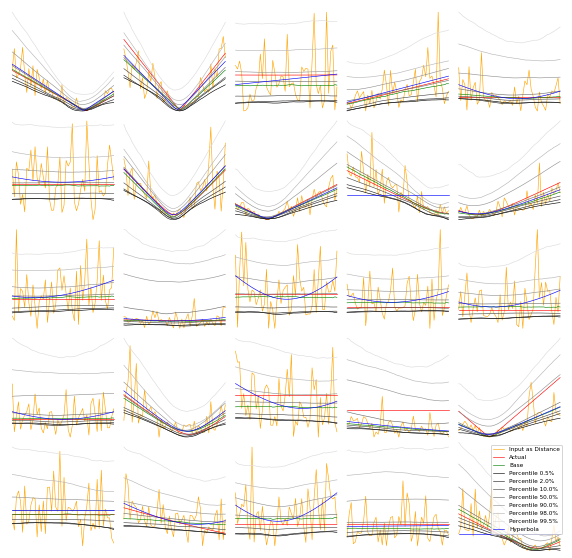

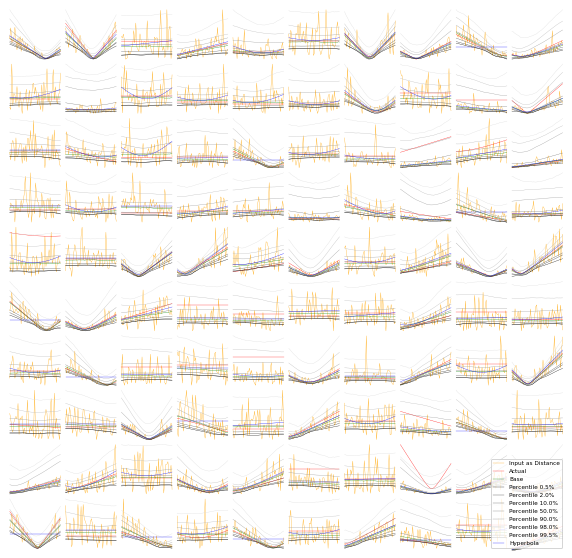

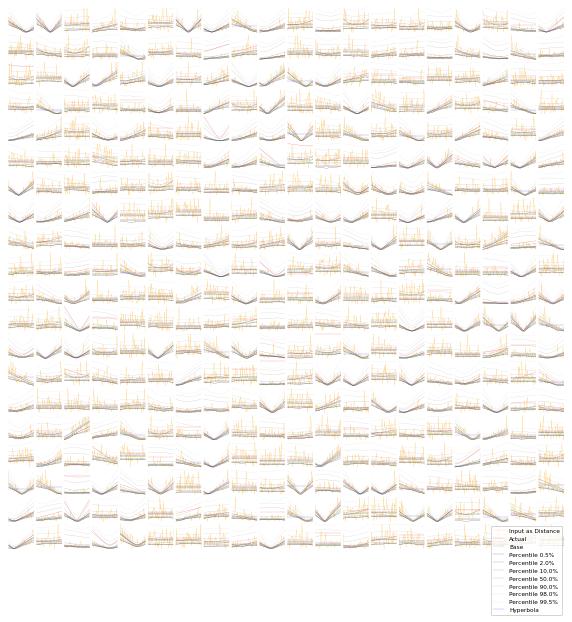

In [41]:
from scipy.optimize import curve_fit
test_results=np.stack([np.load(f'model-rssi-line{samples}-{quantile}.npy') for quantile in quantiles],axis=0)
enumerated_quantiles=sorted(enumerate(quantiles,0),key=lambda x:x[1])
def hyperbola(x,a,b,c):
    return np.sqrt(np.abs(a)+np.abs(b)*(x-c)**2)
test_result_base=np.load(f'model-rssi-line{samples}-base.npy')
for grid_size in grid_sizes:
    idxs=range(grid_size**2)
    fig,ax=plt.subplots(grid_size,grid_size,figsize=(10,10),sharex='all')
    fig.subplots_adjust(wspace=0.0, hspace=0.0)
    plt.margins(0,0)
    axs=ax.reshape(-1)
    linewidth=3/grid_size
    times=np.arange(samples)*sample_rate
    not_found=0
    for i in idxs:
        axs[i].plot(times,RSSI_to_distance(x_test[i]),linewidth=linewidth,label='Input as Distance',color='orange')
        axs[i].plot(times,y_test[i],linewidth=linewidth,label='Actual',color='red')
        axs[i].plot(times,test_result_base[i,:],linewidth=linewidth,label='Base',color='green')
        for q, quantile in sorted(enumerate(quantiles,0),key=lambda x:x[1]):
            axs[i].plot(times,test_results[q,i,:],linewidth=linewidth,label=f'Percentile {quantile:.1%}',color=str(sorted(quantiles).index(quantile)/len(quantiles)))
        if i==grid_size**2-1:
            axs[i].legend(fontsize = 'xx-small')
        axs[i].axis('off')
    fig.savefig(f'model-rssi-line{samples}-size{grid_size}.svg',bbox_inches='tight')
    fig.savefig(f'model-rssi-line{samples}-size{grid_size}.png',dpi=300,bbox_inches='tight')
    for i in idxs:
        x=RSSI_to_distance(x_test[i])
        y=y_test[i]
        try:
            param, param_cov = curve_fit(hyperbola, times, x, p0=[2.5629,1.0,0.0])
        except:
            not_found+=1
        else:
            axs[i].plot(times,hyperbola(times,*param),linewidth=linewidth,label='Hyperbola',color='blue')
        if i==grid_size**2-1:
            axs[i].legend(fontsize = 'xx-small')
    fig.savefig(f'model-rssi-line{samples}-size{grid_size}-withhyperbola.svg',bbox_inches='tight')
    fig.savefig(f'model-rssi-line{samples}-size{grid_size}-withhyperbola.png',dpi=300,bbox_inches='tight')

In [46]:
times=np.arange(samples)*sample_rate
mapes=[[],[]]
maes=[[],[]]
not_found=0
def hyperbola(x,a,b,c):
    return np.sqrt(np.abs(a)+np.abs(b)*(x-c)**2)
for i in range(10000):
    x=RSSI_to_distance(x_test[i])
    y=y_test[i]
    try:
        param, param_cov = curve_fit(hyperbola, times, x, p0=[2.5629,1.0,0.0])
    except:
        not_found+=1
    else:
        mapes[0].append(np.mean(np.abs(1-hyperbola(times,*param)/y))*100)
        mapes[1].append(np.mean(np.abs(1-test_result_base[i,:]/y))*100)
        maes[0].append(np.mean(np.abs(hyperbola(times,*param)-y)))
        maes[1].append(np.mean(np.abs(test_result_base[i,:]-y)))
mapes=np.array(mapes)
maes=np.array(maes)
print(f'MAPE loss is {np.mean(mapes[0]):0.3%} for hyperbolic curve fitting')
print(f'MAPE loss is {np.mean(mapes[1]):0.3%} for machine learning model')
print(f'MAE loss is {np.mean(maes[0]):0.5} for hyperbolic curve fitting')
print(f'MAE loss is {np.mean(maes[1]):0.5} for machine learning model')
print(f'For {not_found/grid_size**2:0.3%} of samples hyperbola was not found')
print(f'Machine learning model has better MAPE {np.mean(mapes[0]>mapes[1]):0.3%} of the time')
print(f'Machine learning model has better MAE {np.mean(maes[0]>maes[1]):0.3%} of the time')

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


MAPE loss is 2398.140% for hyperbolic curve fitting
MAPE loss is 1651.355% for machine learning model
MAE loss is 3.0441 for hyperbolic curve fitting
MAE loss is 2.6052 for machine learning model
For 11.000% of samples hyperbola was not found
Machine learning model has better MAPE 53.465% of the time
Machine learning model has better MAE 52.491% of the time


In [48]:
times=np.arange(samples)*sample_rate
mapes=[[],[]]
maes=[[],[]]
not_found=0
def hyperbola(x,a,b,c):
    return np.sqrt(np.abs(a)+np.abs(b)*(x-c)**2)
for i in range(10000):
    x=RSSI_to_distance(x_test[i])
    y=y_test[i]
    try:
        param, param_cov = curve_fit(hyperbola, times, x, p0=[2.5629,1.0,0.0])
    except:
        not_found+=1
    else:
        mapes[0].append(np.mean(np.abs(1-hyperbola(times,*param)/y))*100)
        mapes[1].append(np.mean(np.abs(1-test_results[0,i,:]/y))*100)
        maes[0].append(np.mean(np.abs(hyperbola(times,*param)-y)))
        maes[1].append(np.mean(np.abs(test_results[0,i,:]-y)))
mapes=np.array(mapes)
maes=np.array(maes)
print(f'MAPE loss is {np.mean(mapes[0]):0.3%} for hyperbolic curve fitting')
print(f'MAPE loss is {np.mean(mapes[1]):0.3%} for machine learning model')
print(f'MAE loss is {np.mean(maes[0]):0.5} for hyperbolic curve fitting')
print(f'MAE loss is {np.mean(maes[1]):0.5} for machine learning model')
print(f'For {not_found/grid_size**2:0.3%} of samples hyperbola was not found')
print(f'Machine learning model has better MAPE {np.mean(mapes[0]>mapes[1]):0.3%} of the time')
print(f'Machine learning model has better MAE {np.mean(maes[0]>maes[1]):0.3%} of the time')

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


MAPE loss is 2398.140% for hyperbolic curve fitting
MAPE loss is 1741.615% for machine learning model
MAE loss is 3.0441 for hyperbolic curve fitting
MAE loss is 2.4931 for machine learning model
For 11.000% of samples hyperbola was not found
Machine learning model has better MAPE 65.398% of the time
Machine learning model has better MAE 66.061% of the time


In [50]:
!cp * drive/My\ Drive/RSSI_model2/

cp: -r not specified; omitting directory 'drive'
cp: -r not specified; omitting directory 'sample_data'
